<a href="https://colab.research.google.com/github/VedangJotaniya/CP441_Project_Repo/blob/gh-pages/sign2text-master/sign2text-master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
from glob import glob
import numpy as np

In [3]:
def square_pad(img, padding_color=[0, 0, 0]):
    """Add margins to image to make it square keeping largest original dimension
    Parameters
    ----------
    img: numpy.ndarray
        Image to be processed
    padding_color: list
        Define background colour to pad image; preserves RGB/BGR colour channel order of img
    Returns
    -------
    padded_img: np.ndarray
        Image padded to a square shape
    """
    height = img.shape[0]
    width = img.shape[1]
    # find difference between longest side
    diff = np.abs(width - height)
    # amount of padding = half the diff between width and height
    pad_diff = diff // 2

    if height > width:
        # letter is longer than it is wide
        pad_top = 0
        pad_bottom = 0
        pad_left = pad_diff
        pad_right = pad_diff
        padded_img = cv2.copyMakeBorder(img,
                                        top=pad_top,
                                        bottom=pad_bottom,
                                        left=pad_left,
                                        right=pad_right,
                                        borderType=cv2.BORDER_CONSTANT,
                                        value=padding_color)
    elif width > height:
        # image is wide
        pad_top = pad_diff
        pad_bottom = pad_diff
        pad_left = 0
        pad_right = 0
        padded_img = cv2.copyMakeBorder(img,
                                        top=pad_top,
                                        bottom=pad_bottom,
                                        left=pad_left,
                                        right=pad_right,
                                        borderType=cv2.BORDER_CONSTANT,
                                        value=padding_color)
    elif width == height:
        padded_img = img.copy()

    return padded_img



In [4]:
def preprocess_for_vgg(img, size=224, color=True):
    """Image pre-processing for VGG16 network
    Parameters
    ----------
    img: numpy.ndarray
        Image to be processed
    size: int
        Size to which image is re-sized (square of shape: size x size)
    color: bool
        If the image is colour (BGR colour channels), then it is zero-centred by mean pixel
    Returns
    -------
    x: np.ndarray
        Pre-processed image ready to feed into VGG16 network; re-shaped to (1, size, size, 3)
    """
    img = cv2.resize(img, (size, size))
    x = np.array(img, dtype=float)
    x_fake_batch = x.reshape(1, *x.shape)
    x = x_fake_batch
    if color:
        # Zero-center by mean pixel
        x[:, :, :, 2] -= 123.68
        x[:, :, :, 1] -= 116.779
        x[:, :, :, 0] -= 103.939 
    return x


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet import MobileNet

from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Sequential, Model

import argparse

# Map model names to classes
MODELS = {
    "vgg16": VGG16,
    "inception": InceptionV3,
    "xception": Xception,
    "resnet": ResNet50,
    "mobilenet": MobileNet
}

# Define path to pre-trained classification block weights - this is
vgg_weights_path = "weights/snapshot_vgg_weights.hdf5"
res_weights_path = "weights/snapshot_res_weights.hdf5"
mob_weights_path = "weights/snapshot_mob_weights.hdf5"

def create_model(model, model_weights_path=None, top_model=True, color_mode="rgb", input_shape=None):
    """Create custom model for transfer learning
    Steps:
    (i) load pre-trained NN architecture
    (ii) (optional) add custom classification block of two fully connected layers
    (iii) load pre-trained model weights, if available
    Parameters
    ----------
    model: str
        choose which pre-trained Keras deep learning model to use for the 'bottom' layers of the custom model
    model_weights_path: str
        optional path to weights for classification block; otherwise, pre-trained weights will be loaded
    top_model: bool
        whether to include custom classification block, or to load model 'without top' to extract features
    color_mode: str
        whether the image is gray scale or RGB; this will determine number of channels of model input layer
    Returns
    -------
    my_model: keras.model
        Model utilised for prediction or training
    """

    # ensure a valid model name was supplied
    if model not in MODELS.keys():
        raise AssertionError("The model parameter must be a key in the `MODELS` dictionary")

    # gray scale or color
    if color_mode == "grayscale":
        num_channels = 1
    else:
        num_channels = 3

    # Create pre-trained model for feature extraction, without classification block
    print("[INFO] loading %s..." % (model,))
    model = MODELS[model](include_top=False,
                          input_shape=(224, 224, 3))

    # For transfer learning
    if top_model:
        # Create classification block
        top_model = Sequential()
        top_model.add(Flatten(input_shape=model.output_shape[1:]))
        top_model.add(Dense(256, activation='relu'))
        top_model.add(Dense(26, activation='softmax'))

        # Load weights for classification block
        print("[INFO] loading model weights.")
        if model_weights_path is not None:
            # user-supplied weights
            print(model_weights_path)
            top_model.load_weights(model_weights_path)
        elif model == "vgg16":
            # pre-trained weights for transfer learning with VGG16
            top_model.load_weights(vgg_weights_path)
        elif model == "resnet":
            # pre-trained weights for transfer learning with ResNet50
            print("ResNet50 pre-trained weights are not available yet, please use VGG16 for now!")
            top_model.load_weights(res_weights_path)
        elif model == "mobnet":
            # pre-trained weights for transfer learning with ResNet50
            print("ResNet50 pre-trained weights are not available yet, please use VGG16 for now!")
            top_model.load_weights(mob_weights_path)

        # Join pre-loaded model + classification block
        print("[INFO] creating model.")
        my_model = Model(inputs=model.input,
                         outputs=top_model(model.output))
        return my_model
    else:
        return model

Instantiate the model by calling given upper function

In [6]:
my_model = create_model(model='resnet')

[INFO] loading resnet...
94773248/94765736 [==============================] - 3s 0us/step
[INFO] loading model weights.
[INFO] creating model.


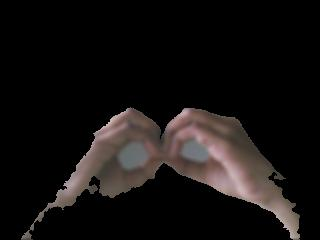

In [11]:
from google.colab.patches import cv2_imshow
img = cv2.imread("515.jpg")
cv2_imshow(img)


In [13]:

x = 313
y = 82
w = 451
h = 568
#cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 0), 3)

# Crop + process captured frame
hand = img
hand = square_pad(hand)


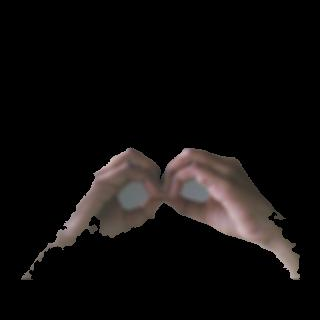

In [14]:
cv2_imshow(hand)

In [15]:

hand = preprocess_for_vgg(hand)



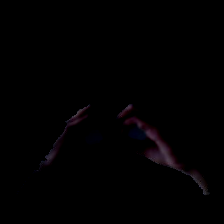

In [18]:
cv2_imshow(hand[0])

In [19]:
# Make prediction
my_predict = my_model.predict(hand,
                              batch_size=1,
                              verbose=0)

In [20]:
print(my_predict)

[[9.8876983e-05 3.6523846e-04 5.8090896e-04 2.5747074e-02 3.1108898e-03
  3.9282492e-01 6.8552718e-03 5.5452611e-02 1.1804549e-04 7.3810145e-03
  2.7968334e-02 8.2623359e-04 1.9046036e-04 3.4883220e-02 5.7827407e-03
  7.0056799e-03 6.6698663e-04 3.5149404e-03 2.6957026e-02 3.7588912e-01
  1.4130241e-02 2.9820499e-03 2.4357289e-03 1.0577020e-03 2.0352325e-03
  1.1394816e-03]]
